In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np

# Cargar el dataset
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/My Drive/MODELOS MONOGRAFIA/otrasinfeccionesMonografia.csv", sep=";")

# Mostrar las primeras filas del dataset para analizar su estructura
data.head()

Mounted at /content/drive


,fecha,semana,tipo,varones,mujeres,total
0,7/1/2019,1,EDA,486,527,1013
1,7/1/2019,1,IRAsinNeumo,1176,1292,2468
2,7/1/2019,1,neumonia,30,36,66
3,14/1/2019,2,EDA,585,627,1212
4,14/1/2019,2,IRAsinNeumo,1789,1963,3752


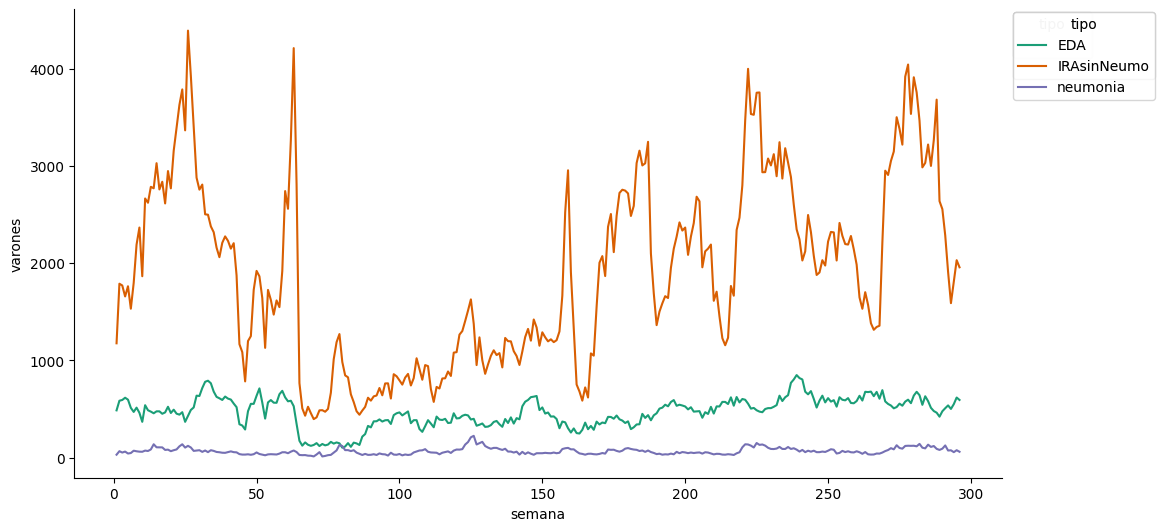

In [ ]:
# @title semana vs varones

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['semana']
  ys = series['varones']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('semana', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('tipo')):
  _plot_series(series, series_name, i)
  fig.legend(title='tipo', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('semana')
_ = plt.ylabel('varones')

In [ ]:
data_ira_varones = data[data['tipo'] == 'IRAsinNeumo'][['fecha', 'varones']]
data_ira_varones['fecha'] = pd.to_datetime(data_ira_varones['fecha'], dayfirst=True)
data_ira_varones = data_ira_varones.sort_values(by='fecha')
data_ira_varones.set_index('fecha', inplace=True)

# Prueba de Dickey-Fuller para verificar estacionaridad
result_ira_varones = adfuller(data_ira_varones['varones'])
print('Prueba de Dickey-Fuller para IRAsinNeumo - Varones:')
print(f'Estadístico de prueba: {result_ira_varones[0]:.4f}')
print(f'P-valor: {result_ira_varones[1]:.4f}')
for key, value in result_ira_varones[4].items():
    print(f'Valor Crítico {key}: {value:.4f}')

Prueba de Dickey-Fuller para IRAsinNeumo - Varones:
Estadístico de prueba: -3.4947
P-valor: 0.0081
Valor Crítico 1%: -3.4528
Valor Crítico 5%: -2.8714
Valor Crítico 10%: -2.5720


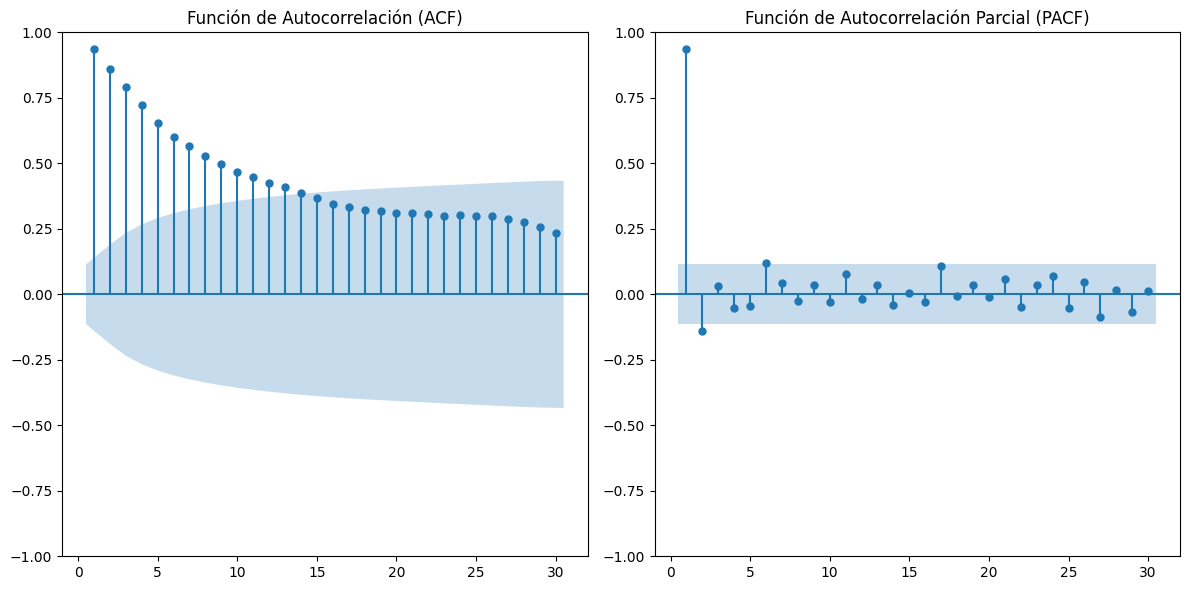

In [ ]:
# Graficar ACF y PACF de la serie original (ya que es estacionaria)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data_ira_varones['varones'], lags=30, zero=False, ax=plt.gca())
plt.title("Función de Autocorrelación (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(data_ira_varones['varones'], lags=30, zero=False, ax=plt.gca())
plt.title("Función de Autocorrelación Parcial (PACF)")

plt.tight_layout()
plt.show()

# ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                varones   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1803.293
Date:                Sat, 30 Nov 2024   AIC                           3612.586
Time:                        17:12:54   BIC                           3623.150
Sample:                    01-07-2019   HQIC                          3616.838
                         - 10-23-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1200      0.364     -0.330      0.742      -0.833       0.593
ma.L1          0.2640      0.362      0.729      0.466      -0.446       0.974
sigma2      1.081e+05   6052.712     17.861      0.0

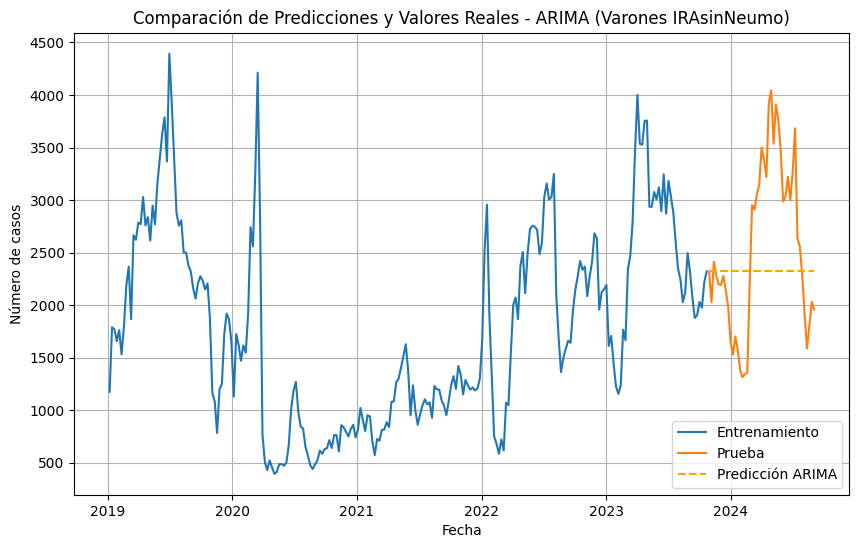

MAE: 685.78
RMSE: 823.40
MAPE: 27.99%
sMAPE: 27.57%


In [ ]:
# Dividir la serie en entrenamiento y prueba (85% entrenamiento, 15% prueba)
train_size_ira_varones = int(len(data_ira_varones) * 0.85)
train_ira_varones, test_ira_varones = data_ira_varones['varones'][:train_size_ira_varones], data_ira_varones['varones'][train_size_ira_varones:]

# Entrenar el modelo ARIMA
model_arima_ira_varones = ARIMA(train_ira_varones, order=(1, 1, 1))
arima_result_ira_varones = model_arima_ira_varones.fit()

# Mostrar el resumen del modelo
print(arima_result_ira_varones.summary())

# Generar predicciones en el conjunto de prueba
predictions_arima_ira_varones = arima_result_ira_varones.forecast(steps=len(test_ira_varones))

# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(train_ira_varones.index, train_ira_varones, label="Entrenamiento")
plt.plot(test_ira_varones.index, test_ira_varones, label="Prueba")
plt.plot(test_ira_varones.index, predictions_arima_ira_varones, color='orange', linestyle='--', label="Predicción ARIMA")
plt.title("Comparación de Predicciones y Valores Reales - ARIMA (Varones IRAsinNeumo)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas de evaluación: MAE, RMSE, MAPE y sMAPE
mae_ira_varones = mean_absolute_error(test_ira_varones, predictions_arima_ira_varones)
rmse_ira_varones = np.sqrt(mean_squared_error(test_ira_varones, predictions_arima_ira_varones))
mape_ira_varones = mean_absolute_percentage_error(test_ira_varones, predictions_arima_ira_varones) * 100  # Convertir a porcentaje
smape_ira_varones = 100 * np.mean(2 * np.abs(test_ira_varones - predictions_arima_ira_varones) / (np.abs(test_ira_varones) + np.abs(predictions_arima_ira_varones)))

# Imprimir métricas
print(f'MAE: {mae_ira_varones:.2f}')
print(f'RMSE: {rmse_ira_varones:.2f}')
print(f'MAPE: {mape_ira_varones:.2f}%')
print(f'sMAPE: {smape_ira_varones:.2f}%')

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos para ARIMA
comparison_df_ira_varones = pd.DataFrame({
    'Fecha': test_ira_varones.index,
    'Reales': test_ira_varones,
    'Predicciones ARIMA': round(predictions_arima_ira_varones)
})

# Mostrar el DataFrame comparativo
print(comparison_df_ira_varones)

                Fecha  Reales  Predicciones ARIMA
2023-10-30 2023-10-30    2317              2326.0
2023-11-06 2023-11-06    2028              2326.0
2023-11-13 2023-11-13    2414              2326.0
2023-11-20 2023-11-20    2282              2326.0
2023-11-27 2023-11-27    2197              2326.0
2023-12-04 2023-12-04    2192              2326.0
2023-12-11 2023-12-11    2280              2326.0
2023-12-18 2023-12-18    2142              2326.0
2023-12-25 2023-12-25    1985              2326.0
2024-01-01 2024-01-01    1648              2326.0
2024-01-08 2024-01-08    1531              2326.0
2024-01-15 2024-01-15    1702              2326.0
2024-01-22 2024-01-22    1571              2326.0
2024-01-29 2024-01-29    1382              2326.0
2024-02-05 2024-02-05    1315              2326.0
2024-02-12 2024-02-12    1344              2326.0
2024-02-19 2024-02-19    1357              2326.0
2024-02-26 2024-02-26    2212              2326.0
2024-03-04 2024-03-04    2952              2326.0


# SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                            varones   No. Observations:                  251
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1461.787
Date:                            Sat, 30 Nov 2024   AIC                           2933.573
Time:                                    17:13:28   BIC                           2950.015
Sample:                                01-07-2019   HQIC                          2940.228
                                     - 10-23-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0654      0.423      0.155      0.877      -0.763       0.894
ma.L1          0.0970      0.420   

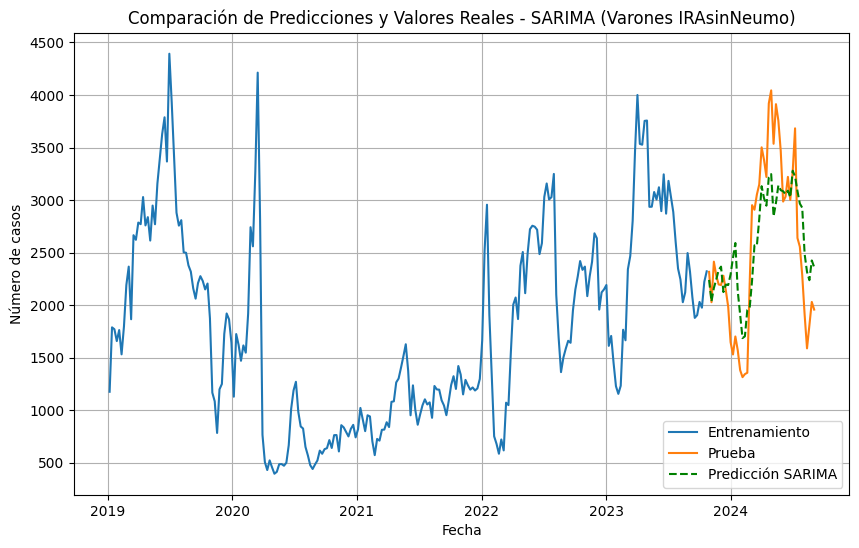

MAE: 399.76
RMSE: 476.66
MAPE: 17.96%
sMAPE: 16.59%


In [ ]:
# Configuración del modelo SARIMA: (p, d, q) x (P, D, Q, s)
# Usaremos los valores (1, 0, 1) para (p, d, q) y probaremos con estacionalidad (P=1, D=1, Q=1, s=30)
model_sarima_ira_varones = SARIMAX(train_ira_varones, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_result_ira_varones = model_sarima_ira_varones.fit()

# Mostrar el resumen del modelo SARIMA
print(sarima_result_ira_varones.summary())

# Generar predicciones en el conjunto de prueba
predictions_sarima_ira_varones = sarima_result_ira_varones.forecast(steps=len(test_ira_varones))

# Graficar predicciones SARIMA vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(train_ira_varones.index, train_ira_varones, label="Entrenamiento")
plt.plot(test_ira_varones.index, test_ira_varones, label="Prueba")
plt.plot(test_ira_varones.index, predictions_sarima_ira_varones, color='green', linestyle='--', label="Predicción SARIMA")
plt.title("Comparación de Predicciones y Valores Reales - SARIMA (Varones IRAsinNeumo)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas de evaluación: MAE, RMSE, MAPE y sMAPE
mae_sarima_ira_varones = mean_absolute_error(test_ira_varones, predictions_sarima_ira_varones)
rmse_sarima_ira_varones = np.sqrt(mean_squared_error(test_ira_varones, predictions_sarima_ira_varones))
mape_sarima_ira_varones = mean_absolute_percentage_error(test_ira_varones, predictions_sarima_ira_varones) * 100  # Convertir a porcentaje
smape_sarima_ira_varones = 100 * np.mean(2 * np.abs(test_ira_varones - predictions_sarima_ira_varones) / (np.abs(test_ira_varones) + np.abs(predictions_sarima_ira_varones)))

# Imprimir métricas
print(f'MAE: {mae_sarima_ira_varones:.2f}')
print(f'RMSE: {rmse_sarima_ira_varones:.2f}')
print(f'MAPE: {mape_sarima_ira_varones:.2f}%')
print(f'sMAPE: {smape_sarima_ira_varones:.2f}%')

In [ ]:
# Crear DataFrame comparativo de los valores reales y predichos para SARIMA
comparison_df_ira_varones_sarima = pd.DataFrame({
    'Fecha': test_ira_varones.index,
    'Reales': test_ira_varones,
    'Predicciones SARIMA': round(predictions_sarima_ira_varones)
})

# Mostrar el DataFrame comparativo
print(comparison_df_ira_varones_sarima)

                Fecha  Reales  Predicciones SARIMA
2023-10-30 2023-10-30    2317               2240.0
2023-11-06 2023-11-06    2028               2035.0
2023-11-13 2023-11-13    2414               2164.0
2023-11-20 2023-11-20    2282               2244.0
2023-11-27 2023-11-27    2197               2335.0
2023-12-04 2023-12-04    2192               2367.0
2023-12-11 2023-12-11    2280               2124.0
2023-12-18 2023-12-18    2142               2196.0
2023-12-25 2023-12-25    1985               2192.0
2024-01-01 2024-01-01    1648               2293.0
2024-01-08 2024-01-08    1531               2450.0
2024-01-15 2024-01-15    1702               2592.0
2024-01-22 2024-01-22    1571               2133.0
2024-01-29 2024-01-29    1382               1910.0
2024-02-05 2024-02-05    1315               1687.0
2024-02-12 2024-02-12    1344               1704.0
2024-02-19 2024-02-19    1357               1954.0
2024-02-26 2024-02-26    2212               1975.0
2024-03-04 2024-03-04    2952  

In [ ]:
# prompt: realiza 8 predicciones a futuro

# Generar 8 predicciones a futuro con el modelo SARIMA
future_steps = 8
future_predictions_sarima_ira_varones = sarima_result_ira_varones.get_forecast(steps=future_steps)

# Obtener las predicciones y los intervalos de confianza
future_predictions = future_predictions_sarima_ira_varones.predicted_mean
confidence_intervals = future_predictions_sarima_ira_varones.conf_int()

# Crear un índice de fechas para las predicciones futuras
last_date = data_ira_varones.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(weeks=1), periods=future_steps, freq='W')

# Crear un DataFrame para las predicciones futuras
future_predictions_df = pd.DataFrame({
    'Fecha': future_dates,
    'Predicciones SARIMA': future_predictions,
    'Límite inferior': confidence_intervals['lower varones'],
    'Límite superior': confidence_intervals['upper varones']
})

# Imprimir las predicciones futuras
future_predictions_df

,Fecha,Predicciones SARIMA,Límite inferior,Límite superior
2023-10-30,2024-09-15,2240.400183,1502.402829,2978.397537
2023-11-06,2024-09-22,2035.158317,903.584463,3166.732171
2023-11-13,2024-09-29,2163.818247,739.120865,3588.515630
2023-11-20,2024-10-06,2243.638762,576.320274,3910.957250
2023-11-27,2024-10-13,2334.654535,455.772662,4213.536407
2023-12-04,2024-10-20,2366.749680,297.825559,4435.673802
2023-12-11,2024-10-27,2124.468879,-118.452697,4367.390455
2023-12-18,2024-11-03,2195.939834,-208.420242,4600.299910


   Fecha  Real  Predicción
0      1  2074        2240
1      2  1985        2035
2      3  1694        2164
3      4  1767        2244
4      5  1479        2335
5      6  1534        2367
6      7  1619        2124
7      8  1658        2196


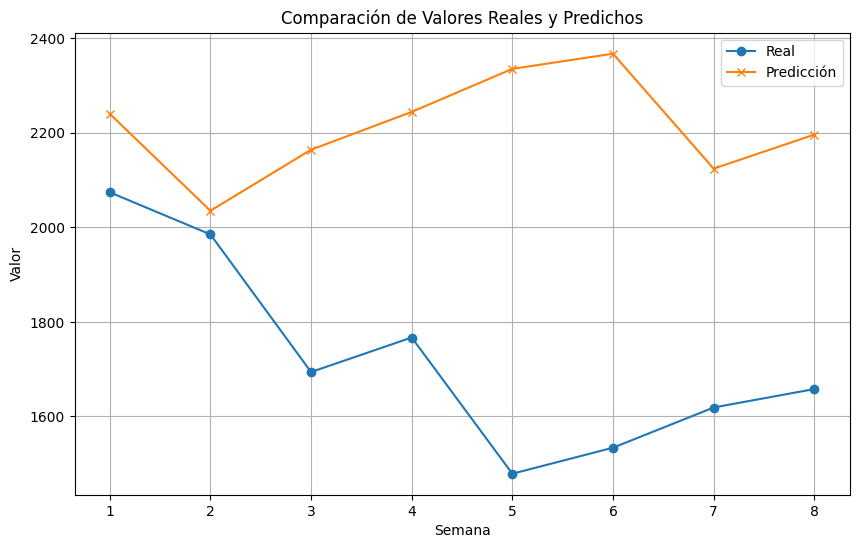

MAE: 486.88
RMSE: 553.35
MAPE: 30.14%
sMAPE: 25.10%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# prompt: estos son los 8 valores reales, quiero que contrastes tu predicción con estos en tabla y grafica, además evalualo con las metricas MAE, RMSE y sMAPE MAPE:
# 2074
# 1985
# 1694
# 1767
# 1479
# 1534
# 1619
# 1658

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Valores reales proporcionados
real_values = [2074, 1985, 1694, 1767, 1479, 1534, 1619, 1658]

# Obtener las últimas 8 predicciones del modelo SARIMA (asumiendo que future_predictions_df existe)
# Asegúrate de que future_predictions_df esté definido en tu código anterior
try:
  predicted_values = future_predictions_df['Predicciones SARIMA'].values[-8:].astype(int)
except NameError:
  print("Error: future_predictions_df no está definido. Asegúrate de ejecutar el código completo que incluye la generación de predicciones.")
  predicted_values = [0] * 8 # Valor por defecto en caso de error

# Crear DataFrame para la comparación
comparison_df = pd.DataFrame({
    'Fecha': range(1, 9),  # Índice para las 8 predicciones
    'Real': real_values,
    'Predicción': predicted_values
})

print(comparison_df)

# Crear la gráfica de comparación
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Fecha'], comparison_df['Real'], label='Real', marker='o')
plt.plot(comparison_df['Fecha'], comparison_df['Predicción'], label='Predicción', marker='x')
plt.xlabel('Semana')
plt.ylabel('Valor')
plt.title('Comparación de Valores Reales y Predichos')
plt.legend()
plt.grid(True)
plt.show()


# Calcular métricas
mae = mean_absolute_error(real_values, predicted_values)
rmse = mean_squared_error(real_values, predicted_values, squared=False)  # RMSE
mape = mean_absolute_percentage_error(real_values, predicted_values) * 100
smape = 100/len(real_values) * np.sum(2 * np.abs(real_values - predicted_values) / (np.abs(real_values) + np.abs(predicted_values)))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")